# Práctica 11: Estimación del rendimiento.

## Realizado por:
- Susana Suárez Mendoza
- Mara Pareja del Pino

In [1]:
import pandas as pd
from sklearn import tree, model_selection, svm, feature_selection
import matplotlib.pyplot as plt

### Ejercicio 1: Clasificación de células.

1. Dividir el conjunto de datos en entrenamiento y test

In [2]:
data = pd.read_csv("wisconsin diagnostic breast cancer.csv")
data_y = data['Diagnosis'].to_numpy()
data_x = data.iloc[:,2:].to_numpy()

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_x, data_y, test_size=0.3, random_state=1)

2. Entrenar un árbol de decisión con los parámetros de la clase por defecto y evaluar su rendimiento.


In [4]:
clf_defecto = tree.DecisionTreeClassifier()
clf_defecto = clf_defecto.fit(X_train, y_train)


In [5]:
print("Rendimiento del modelo con los parametros por defecto")
print("Precisión sobre el conjunto de entrenamiento: {:.2f}".format(clf_defecto.score(X_train, y_train)))  
print("Precisión sobre el conjunto de test: {:.2f}".format(clf_defecto.score(X_test, y_test)))

Rendimiento del modelo con los parametros por defecto
Precisión sobre el conjunto de entrenamiento: 1.00
Precisión sobre el conjunto de test: 0.95


3. Buscar la mejor combinación en cuanto a profundidad máxima y criterio de división teniendo en cuenta la naturaleza del problema que es un diagnóstico médico.

In [6]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15]
criterion = ['gini', 'entropy', 'log_loss']
rend_criterio =[]

for criterio in criterion:
    rendimientos = []
    for depth in max_depth:
        clf = tree.DecisionTreeClassifier(max_depth=depth, criterion=criterio)
        clf = clf.fit(X_train, y_train)
        rendimientos.append(clf.score(X_test, y_test))
    rend_criterio.append(rendimientos)

df = pd.DataFrame(rend_criterio, index=criterion, columns=max_depth)
df = df.transpose()
display(df)

,gini,entropy,log_loss
1,0.853801,0.847953,0.847953
2,0.865497,0.871345,0.871345
3,0.883041,0.883041,0.883041
4,0.929825,0.918129,0.923977
5,0.947368,0.900585,0.912281
6,0.947368,0.900585,0.918129
7,0.929825,0.894737,0.906433
8,0.953216,0.906433,0.900585
9,0.923977,0.906433,0.900585
10,0.959064,0.912281,0.906433


En definitiva, la mejor combinación es aquella cuyo criterio es gini con profundidad 5, 8 o 9. Sin embargo, nuestro problema es de naturaleza médica por lo que las muestras no están distribuidas uniformemente, entonces se deberías escoger el criterio entropía con profundidad 4 que se utiliza a menudo en problemas de clasificación binaria y cuando las clases están distribuidas de manera desigual.

In [7]:
clf_best = tree.DecisionTreeClassifier(max_depth=4, criterion='entropy')
clf_best = clf.fit(X_train, y_train)

4. Mostrar gráficamente los árboles obtenidos en el punto 2 y 3 y compararlos

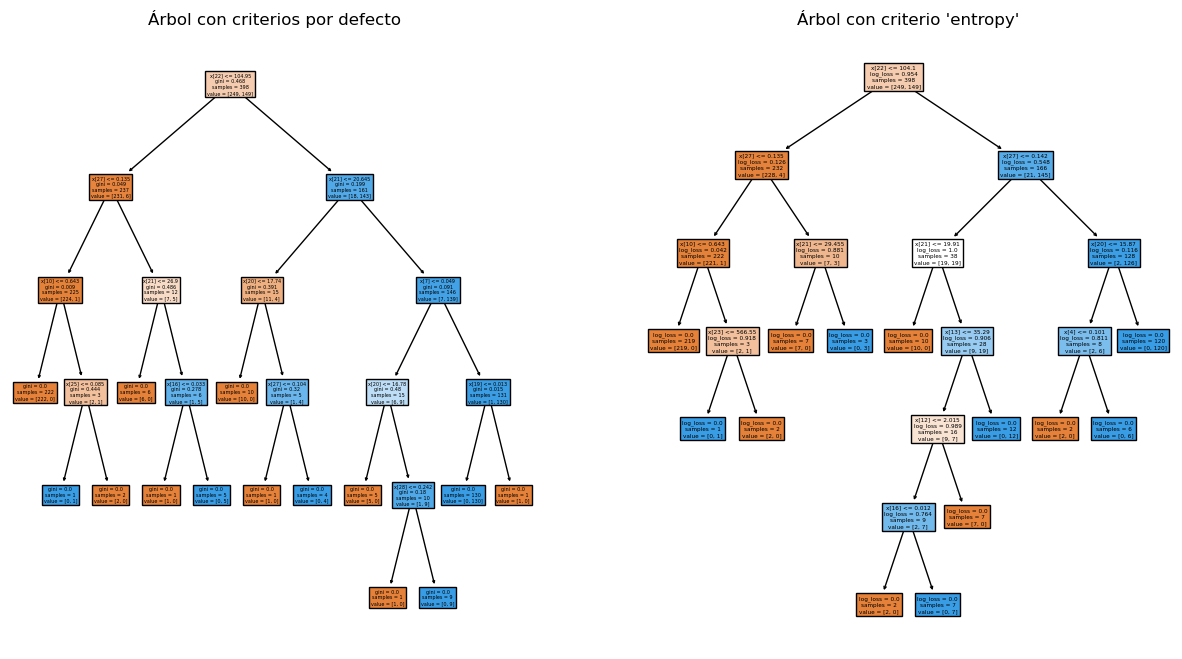

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
tree.plot_tree(clf_defecto, ax=ax[0], filled=True)
ax[0].set_title("Árbol con criterios por defecto")
tree.plot_tree(clf_best, ax=ax[1],filled=True)
ax[1].set_title("Árbol con criterio 'entropy'")
plt.show()

### Ejercicio 2: Selección de características con árbol de decisión.

1. Entrenar un árbol de decisión y determinar qué características forman parte del árbol. 

In [9]:
clf = tree.DecisionTreeClassifier()  
clf = clf_best.fit(X_train, y_train)

importances = clf.feature_importances_
nombres = []

print("Caracteristicas que forman parte del arbol")
print("==========================================\n")
for i in range(len(importances)):
    if importances[i] > 0:
        nombres.append(data.columns[i+2])
        print(data.columns[i+2])

n= len(nombres)

Caracteristicas que forman parte del arbol

Mean smoothness
Mean concavity
Standard Error perimeter
Standard Error area
Worst radius
Worst texture
Worst perimeter
Worst concave points


2. Entrenar una máquina de vectores soporte con las características seleccionadas en el paso anterior.

In [10]:
data_x_selected = data[nombres].to_numpy()

X_train_selected, X_test_selected, y_train, y_test = model_selection.train_test_split(data_x_selected, data_y, test_size=0.3, random_state=1)

In [11]:
clf = svm.SVC()
clf = clf.fit(X_train_selected, y_train)

3. Seleccionar el mismo número de características que en el primer paso utilizando la clase SelectKBest y como medida de score la información mutua (mutual_info_classif).

In [12]:
selector = feature_selection.SelectKBest(feature_selection.mutual_info_classif, k=n)
X_selected_kbest = selector.fit_transform(X_train, y_train)
X_test_selected_kbest = selector.transform(X_test)

print("\nCaracteristicas seleccionadas por SelectKBest")
print("=============================================\n")
names_kbest = data.columns[selector.get_support(indices=True)+2]
for name in names_kbest:
    print(name)



Caracteristicas seleccionadas por SelectKBest

Mean radius
Mean perimeter
Mean area
Mean concave points
Worst radius
Worst perimeter
Worst area
Worst concave points


In [13]:
print("\nCaracteristicas seleccionadas por SelectKBest y por el arbol")

for name in names_kbest:
    if name in nombres:
        print(name)


Caracteristicas seleccionadas por SelectKBest y por el arbol
Worst radius
Worst perimeter
Worst concave points


4. Entrenar una máquina de vectores soporte con las características seleccionadas con SelectKBest.

In [14]:
clf_kbest = svm.SVC()
clf_kbest = clf_kbest.fit(X_selected_kbest, y_train)

5. Comparar el rendimiento de las dos máquinas de vectores soporte entrenadas en el paso 2 y 4.

In [15]:
rendimiento = [[clf.score(X_test_selected, y_test), clf_kbest.score(X_test_selected_kbest, y_test)]]
df = pd.DataFrame(rendimiento, index=['Rendimiento'], columns=['Arbol', 'Kbest'])
display(df)

,Arbol,Kbest
Rendimiento,0.929825,0.906433


Finalmente, seleccionar las características emdiante árboles de decisión supera un 2% el rendimiento de las características seleccionadas por el selectKBest.